In [1]:
import pandas as pd
import sklearn
import statsmodels
import scipy

print('pandas: ',pd.__version__)
print('sklearn: ',sklearn.__version__)
print('statsmodels: ',statsmodels.__version__)
print('scipy: ',scipy.__version__)


pandas:  0.24.2
sklearn:  0.21.2
statsmodels:  0.10.0
scipy:  1.3.0


In [2]:
from capstone_data_eng import *
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.proportion import proportion_confint
from plotting_functions import *


from scipy.stats import randint as sp_randint , uniform

from matplotlib.colors import BoundaryNorm, LogNorm
from statsmodels.stats.proportion import proportion_confint

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc , confusion_matrix
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, fbeta_score, make_scorer, auc

from inspect import signature

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.manifold import TSNE

import pickle

In [3]:
out, profile_all, portfolio, offers_all, transactions_all, transactions_during_offer, transactions_outside_offer = load_data_cv(
        person_split=None, rename_offers=True, time_split_min=None, time_split_max=None,
        add_transactions=False, skip_overlap=False, skip_add_purchases=False, calc_net_offer_time=True,
        assign_to='ignore', location='local')

/home/marco/UD/Starbucks_capstone/capstone_data_eng.py:741: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  profile_all = load_profile(location=location)


offer received     76277
offer viewed       57725
offer completed    33579
Name: event, dtype: int64
er,ec,ev
(76277, 3) (33579, 4) (57725, 3)
er  (76277, 6)
persons with no offers received in timeframe:  6
transactions_during_offer.shape: (122652, 7)
(76277, 27)
add_stats_by_person:
(76277, 38)
(76277, 44)
(76277, 50)
(76277, 51)
(76277, 60)


In [4]:
def fit_col_transformer(X_train,categorical_features,numeric_features):
    ohe= OneHotEncoder(handle_unknown='ignore')
    ssc=StandardScaler()

    ohe.fit(X_train[categorical_features])
    ssc.fit(X_train[numeric_features])
    return(ohe,ssc)
    
def apply_transformer(ohe,ssc,X,categorical_features,numeric_features,binary_features):
    xoh=ohe.transform(X[categorical_features]).todense()
    dfoh=pd.DataFrame(data=xoh,columns=ohe.get_feature_names(input_features=categorical_features))
    
    xn=ssc.transform(X[numeric_features])
    dfxn=pd.DataFrame(data=xn,columns=numeric_features)
    
    if len(binary_features)>0:
        dfxb=X[binary_features].astype(int)
        out=pd.concat( (dfoh,dfxn,dfxb),axis=1 )
    
    out=pd.concat( (dfoh,dfxn),axis=1 )
    
    return(out)
        

In [41]:
def plot_roc(y_prob,y_test,y_label,  first_plot=True):
    # compare ROC 

    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    if first_plot:
        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                 label='Chance', alpha=.8)
        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC')
        plt.legend(loc="lower right");
        plt.axis('square');

    plt.plot(fpr, tpr, lw=1, alpha=1, label='ROC %s(AUC = %0.2f)' % (y_label,roc_auc));
    plt.legend(loc="lower right");
        

## Imputation of missing values

We use the mean values extracted in the EDA part to impute missing values.
We also create the features discussed in the EDA part.

In [6]:
out.income=out.income.fillna(65400)
out.age=out.age.fillna(54)
out.gender=out.gender.fillna('M')
out['group118']=out['age']>116
out.loc[out['age']>116,'age']=54

out['binned_income'] = pd.cut(out['income'],bins= np.arange(0,14)*1e4,labels=np.arange(0,13)*10)
out['binned_age'] = pd.cut(out['age'],bins= np.arange(0,120,10) ,labels=np.arange(0,120,10)[:-1])

We separate the columns depending on their content and type.

In [10]:
c_bin_offer=['web','email', 'mobile', 'social','viewed', 'rewarded', 'received', 'comp_not_viewed', 'completed']

c_num_time=['offer_received', 'offer_viewed', 'offer_completed', 'offer_end',]
c_num_offer=['overlaps','offer_reward', 'difficulty', 'duration'  ]
c_num_leak_offer=['Tpay_offer', 'Npay_offer', 'Maxpay_offer', 'Minpay_offer', 'Netpay_offer', 'Avg_pay_offer', 
                  'Avg_pay_outside', 'Avg_D_O','reward', 'duration_viewed','duration_effective', ]
c_num_person=['age', 'income', 'Tpay_out', 'Npay_out', 'user_time' ,'binned_age','binned_income']
c_num_person_ignore=['became_member_on',   'joined_year', 'joined_month','joined_week', 'gender_num',  'duration_hours',]

c_cat_offer=[ 'offer_type' ]

c_bin_person=['group118']
c_cat_person=['gender',]
c_drop_order=['person','offer']

c_num_offers=['p_c_r_ratio','p_c_v_ratio', 'p_cnv_r_ratio','Tpay_offers_tot',
       'Npay_offers_tot', 'Maxpay_offers_tot', 'Minpay_offers_tot',
       'Trewards_tot', 'Nrewards_tot', 'tot_gross_offer_time',
       'tot_net_offers_time', 'tot_not_offers_time', 'Avg_pay_offers',
       'Net_pay_offers', 'Avg_net_pay_offers', 
       'Avg_D_OS','Avg_D_nOS']


In [12]:
c_total=c_bin_offer+c_bin_person+c_num_time+c_num_offer+c_num_leak_offer+c_num_person+c_num_person_ignore + \
    c_cat_offer+c_cat_person+c_num_offers+ c_drop_order

In [13]:
display(set(c_total) ^ set(out.columns))

set()

In [14]:
print("columns with nan:")
fna=list(out.columns[out.isna().any()])
print(fna)

columns with nan:
['offer_viewed', 'offer_completed']


# Classification of Completed not viewed offers

In [15]:
outd=out.copy()
outd=outd.drop(columns=c_num_leak_offer+c_num_offers+c_num_person_ignore+[ 'offer_viewed', 'offer_completed', 'offer_end'])
outd=outd.drop(columns=['viewed', 'rewarded', 'received', 'comp_not_viewed', 'completed','overlaps'])
outd=outd.drop(columns=['person','email'])
outd=outd.drop(columns=['age','income'])

Y=out['comp_not_viewed']

In [16]:
X_train, X_test, y_train, y_test = train_test_split( outd, Y, test_size=0.3, random_state=0)

In [17]:
numeric_features = ['Tpay_out', 'Npay_out']
binary_features=[       'web', 'mobile', 'social','group118']

categorical_features = ['offer', 'offer_received', 'gender', 'difficulty', 'duration', 'offer_type',
       'offer_reward', 'gender' , 'binned_income', 'binned_age']
    

In [18]:
ohe,ssc=fit_col_transformer(X_train,categorical_features,numeric_features)
XT_train=apply_transformer(ohe,ssc,X_train,categorical_features,numeric_features,binary_features)
XT_test=apply_transformer(ohe,ssc,X_test,categorical_features,numeric_features,binary_features)

In [19]:
clf=RandomForestClassifier( bootstrap=20, criterion="entropy",class_weight="balanced")

In [20]:
clf.fit(XT_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=20, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=10, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [21]:
y_pred=clf.predict(XT_test)
y_prob=clf.predict_proba(XT_test)[:, 1]

print("model score: %.3f" % clf.score(XT_test, y_test))

model score: 0.842


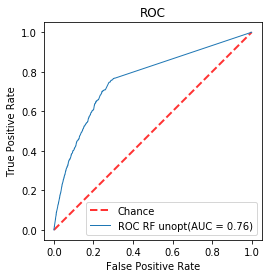

In [42]:
plot_roc(y_prob,y_test,'RF unopt',  first_plot=True)

# Optimization of the hyperparameters

In [30]:
param_dist = {
              "n_estimators": sp_randint(1, 40),
              "max_depth": sp_randint(1, 20),
              "max_features": sp_randint(1, 40),
              "min_samples_split": sp_randint(2, 20),
            }

# run randomized search
n_iter_search = 30
clf = RandomForestClassifier( bootstrap=20, criterion="entropy",class_weight="balanced")
random_search = RandomizedSearchCV(clf,scoring='roc_auc', param_distributions=param_dist,  cv=5, iid=False,  n_iter=n_iter_search)

random_search.fit(XT_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=20,
                                                    class_weight='balanced',
                                                    criterion='entropy',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jo

In [31]:
sorted(random_search.cv_results_.keys())
display(random_search.cv_results_['mean_test_score'])
clf=random_search.best_estimator_

array([0.85537972, 0.86234071, 0.8585667 , 0.85938427, 0.86171254,
       0.78192971, 0.86237218, 0.86286214, 0.83122649, 0.8208762 ,
       0.85496936, 0.8051249 , 0.84190334, 0.86373125, 0.86178698,
       0.84080376, 0.85636111, 0.86143703, 0.84175632, 0.85904669,
       0.85276493, 0.8404553 , 0.85592727, 0.85536611, 0.84303385,
       0.83331453, 0.84239381, 0.8403768 , 0.85967896, 0.85417696])

In [32]:
y_pred_o=clf.predict(XT_test)
y_prob_o=clf.predict_proba(XT_test)[:, 1]


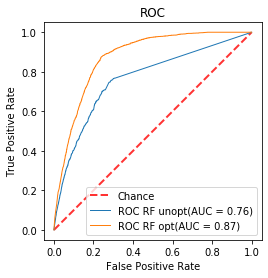

In [43]:
plot_roc(y_prob,y_test,'RF unopt',  first_plot=True)
plot_roc(y_prob_o,y_test,'RF opt',  first_plot=False)
plt.legend(loc=4)

In [36]:
display(confusion_matrix(y_test, clf.predict(XT_test)))

array([[16112,  5049],
       [  217,  1506]])

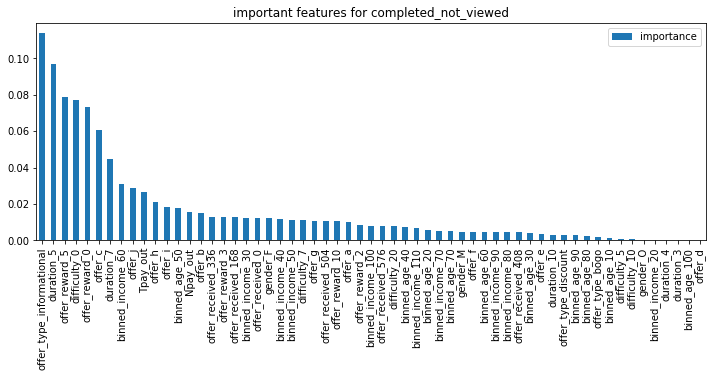

In [34]:
feat=pd.DataFrame.from_dict(dict(zip(XT_train.columns,clf.feature_importances_) ), orient='index',columns=['importance'])
feat=feat.sort_values(by=['importance'],ascending=False)

feat.plot(kind='bar',figsize=(12,4));
plt.title('important features for completed_not_viewed');


# Decision Tree Classifier

In [37]:
from sklearn.tree import DecisionTreeClassifier

# specify parameters and distributions to sample from
param_dist = {
              "max_depth": sp_randint(2, 50),
              "max_features": sp_randint(1, 50),
              "min_samples_split": uniform(.1, .9),
    
            }

# run randomized search
n_iter_search = 20
clf = DecisionTreeClassifier(  criterion="entropy",class_weight="balanced")

random_search = RandomizedSearchCV(clf,scoring='roc_auc', param_distributions=param_dist,  cv=5, iid=False,  n_iter=n_iter_search)

random_search.fit(XT_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    criterion='entropy',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=None,
                                                    splitte

In [38]:
sorted(random_search.cv_results_.keys())
display(random_search.cv_results_['mean_test_score'])
clf=random_search.best_estimator_

array([0.81074552, 0.76252969, 0.62760073, 0.81779675, 0.76862862,
       0.81868377, 0.78242403, 0.69119658, 0.73526256, 0.74064711,
       0.73463107, 0.68508799, 0.73258438, 0.68721002, 0.70059015,
       0.73401213, 0.70626632, 0.69466616, 0.83611927, 0.78017039])

In [39]:
y_pred_t=clf.predict(XT_test)
y_prob_t=clf.predict_proba(XT_test)[:, 1]


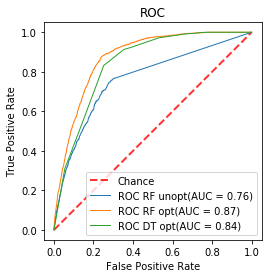

In [44]:
plot_roc(y_prob,y_test,'RF unopt',  first_plot=True)
plot_roc(y_prob_o,y_test,'RF opt',  first_plot=False)
plot_roc(y_prob_t,y_test,'DT opt',  first_plot=False)

In [46]:
display(confusion_matrix(y_test, clf.predict(XT_test)))

array([[15834,  5327],
       [  290,  1433]])

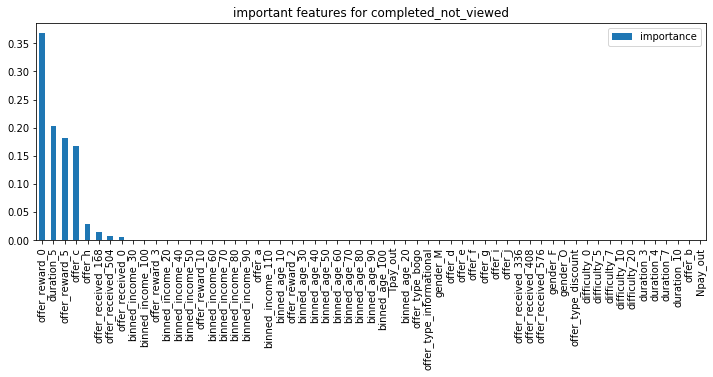

In [45]:
feat=pd.DataFrame.from_dict(dict(zip(XT_train.columns,clf.feature_importances_) ), orient='index',columns=['importance'])
feat=feat.sort_values(by=['importance'],ascending=False)

feat.plot(kind='bar',figsize=(12,4));
plt.title('important features for completed_not_viewed');

In [56]:
from sklearn import tree
import graphviz 

dot_data = tree.export_graphviz(clf, out_file=None,   feature_names=XT_test.columns,
                                class_names=True,  filled=True, rounded=True,  special_characters=True)  
graph = graphviz.Source(dot_data)  
graph
graph.render(filename='graph',format='png');

